# Assigment 04: Due 9/30

You can use these imports

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit #simpliest scipy fitting method
import scipy.special as sf
import math
%matplotlib notebook

# Problem 1a

Using Monte Carlo techniques discusses in *02_Integration_MC* notebook, solve the following integral and compare it to the exact solution:

$\int_0^2 \frac{2}{(2^2 + x^2)^{3/2}}dx$

In your Monte Carlo integration, use 10,000 random points.

In [46]:
N = 10000
x0 = 0
x1 = 2

def func(x):
    return (2/((2**2) + (x**2))**1.5)

In [48]:
x = np.linspace(x0, x1, N)
y = func(x)

fmax = max(y)
print('fmax = ' + str(fmax))

# Generate random data
x_rand = x0 + (x1 - x0)*np.random.random(N) #between x0 and x1
y_rand = np.random.random(N)*fmax

# Fill below and above arrays
ind_below = np.where(y_rand < func(x_rand))
ind_above = np.where(y_rand >= func(x_rand))

# Area of the rectangel * the ratio of points below function to total points
ratio = float(len(ind_below[0])/N)
area = (x1-x0)*fmax
integral = ratio*area
print(' ratio: {0}\n area: {1}\n integral: {2}\n'.format(ratio,area,integral)) 

print("From Wolfram Alpha, exact integral value: "  + str(0.353553))

fmax = 0.25
 ratio: 0.7101
 area: 0.5
 integral: 0.35505

From Wolfram Alpha, exact integral value: 0.353553


# 1b

Make a scatter plot of points below and above the integrand function. This is the some type of graph shown in the *02_Integration_MC* notebook with the blue and green points.

<IPython.core.display.Javascript object>


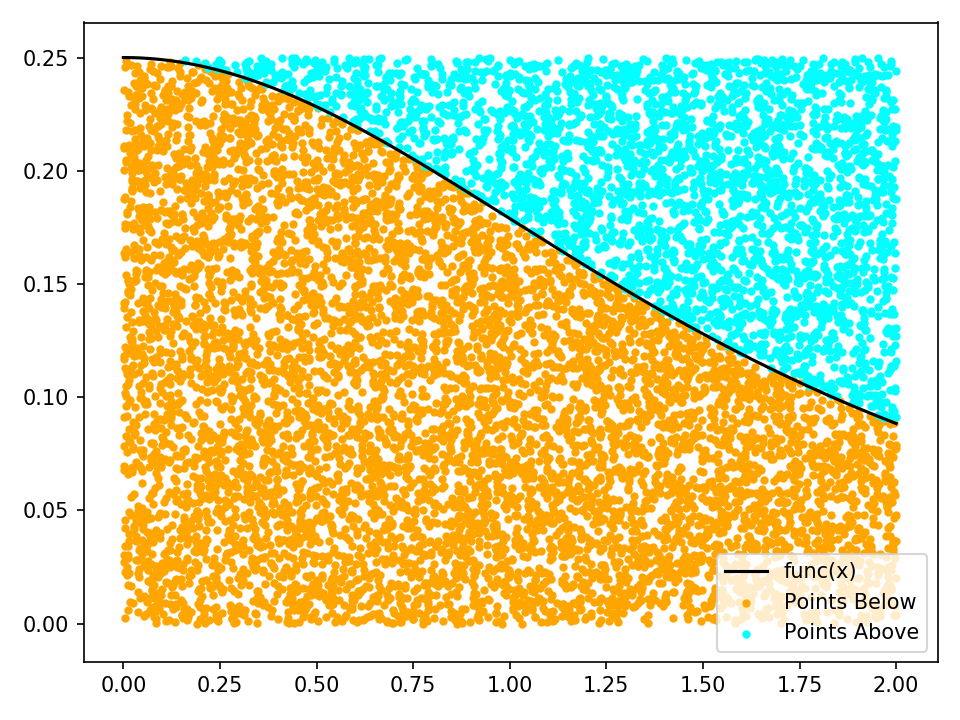

In [49]:

fig = plt.figure('Monte Carlo Integration of func')
plt.scatter(x_rand[ind_below], y_rand[ind_below], color = "orange", marker = '.',label='Points Below')
plt.scatter(x_rand[ind_above], y_rand[ind_above], color = "cyan", marker = '.', label = 'Points Above')
plt.plot(x, y, color = "black", label= 'func(x)')
plt.legend()
plt.tight_layout();

# Problem 2a
Read in the data set *./data/decay_data.txt*, this lists the time in days, number of particles, and the uncertianty on the particles. This is the same radio active decay data set used in our fitting example *Fitting_Lecture_Notes* from Module 2b.

Plot the data with its error bars.


<IPython.core.display.Javascript object>


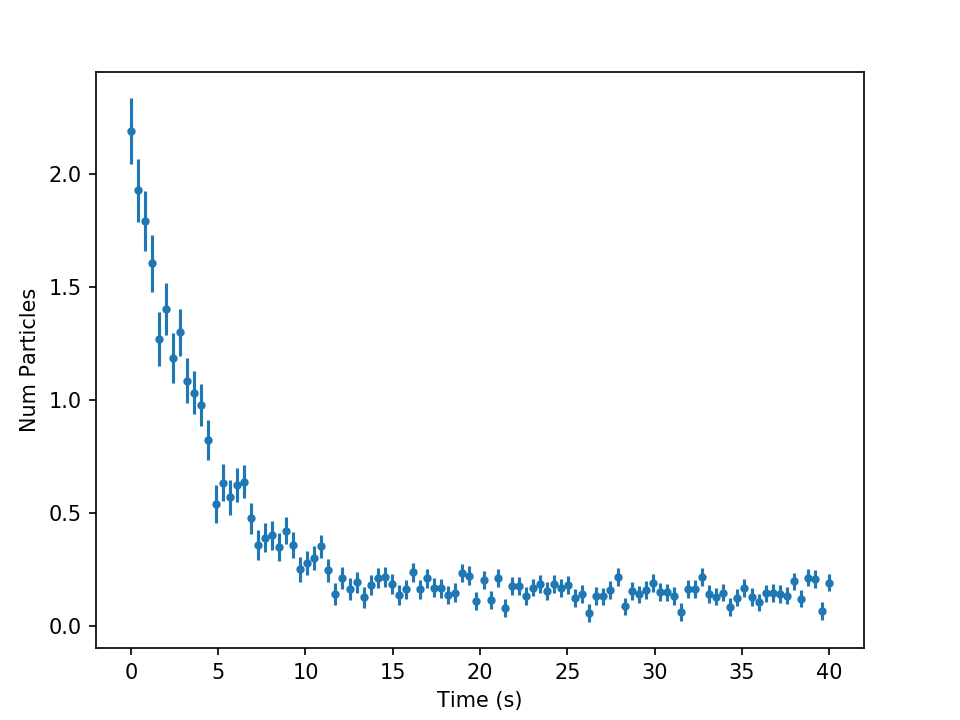

Text(0, 0.5, 'Num Particles')

In [50]:
import pandas as pd 

t, num_particles, particle_uncertainty = np.loadtxt('data/decay_data.txt', unpack=True)

fig2 = plt.figure('Radioactive Decay')
ax2 = fig2.add_axes([0.1,0.1,0.8,0.8])
ax2.errorbar(x=t, y=num_particles, yerr=particle_uncertainty, fmt='.')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Num Particles')

# Problem 2b

Fit the data with 3 fit parameters using MCMC MH algorithm. You should take 10,000 steps and impliment the random test on $\chi ^2$, like we did our *03_MC_Fit* example notebook using the *get_chi_squared* function. For this we will use a function template of: $y = p_0 \cdot e^{-t/p_1} + p_2$,

where $p_0, p_1$, and $p_2$ are the fit parameters. When fitting you should choose starting values of $p_0 = p_1 = p_2 = 1.0$ to avoid nan errors.

In [51]:
def get_chi_squared(t, p, sigma, params):
    '''Returns the chi squared of the fit'''
    RR = 0.0
    for i in range(len(t)):
        p_prime = (params[0] * (math.e**(-t[i]/params[1])) + params[2])
        RR = RR + ((p[i] - p_prime)/sigma)**2
    return RR


In [52]:
N = 10000
init_p = [1.0, 1.0, 1.0]
sigma = 1.0
par_list, RRs = [init_p], [get_chi_squared(t, num_particles, sigma, init_p)]

for i in range(N):
    test_par = [np.random.normal(par_list[-1][0], 0.5), np.random.normal(par_list[-1][1], 0.5), np.random.normal(par_list[-1][2], 0.5)]
    RR_test = get_chi_squared(t, num_particles, sigma, test_par)
    test = (np.random.random() <= (RRs[-1])/RR_test)
    if test: 
        par_list.append(test_par)
        RRs.append(RR_test)
    else:
        par_list.append(par_list[-1])
        RRs.append(RRs[-1])
        
RR_min = np.amin(RRs) #find min R2
chisq = RR_min
best_i = RRs.index(RR_min) #Get the index
best_pars = par_list[best_i]  #get the parameters  
print("best p0 = {0}, best p1 = {1}, best p2 = {2}, chi**2 = {3}, loc = {4}".format(best_pars[0], best_pars[1], best_pars[2], RR_min, best_i) ) 

<ipython-input-51-f7ea2ff7da3c>:6: RuntimeWarning: overflow encountered in double_scalars
  RR = RR + ((p[i] - p_prime)/sigma)**2
<ipython-input-51-f7ea2ff7da3c>:5: RuntimeWarning: overflow encountered in double_scalars
  p_prime = (params[0] * (math.e**(-t[i]/params[1])) + params[2])


best p0 = 2.035670445806751, best p1 = 3.3153108284812305, best p2 = 0.20052993203058073, chi**2 = 0.5432836490234897, loc = 115


# Problem 2c

What is the reduced $\chi^2$ of your fit and the p-value?
Is this a good fit?

In [53]:
dof = len(num_particles) - len(init_p) - 1
red_chisq = chisq/dof
pval = sf.gammainc(dof/2, chisq/2)
print("Reduced Chi-Squared Value: {0}, p-value: {1}".format(red_chisq, pval))

# Excellent reduced chi-squared value and p-value 

Reduced Chi-Squared Value: 0.005659204677328018, p-value: 4.1915182347409425e-89


# Problem 2d

Plot on the same graph your data and the line showin the fitted function.

In [54]:
def fit_line(t, p): #p=[p0,p1,p2]
    return (p[0]*(math.e**(-t/p[1])) + p[2])

<IPython.core.display.Javascript object>


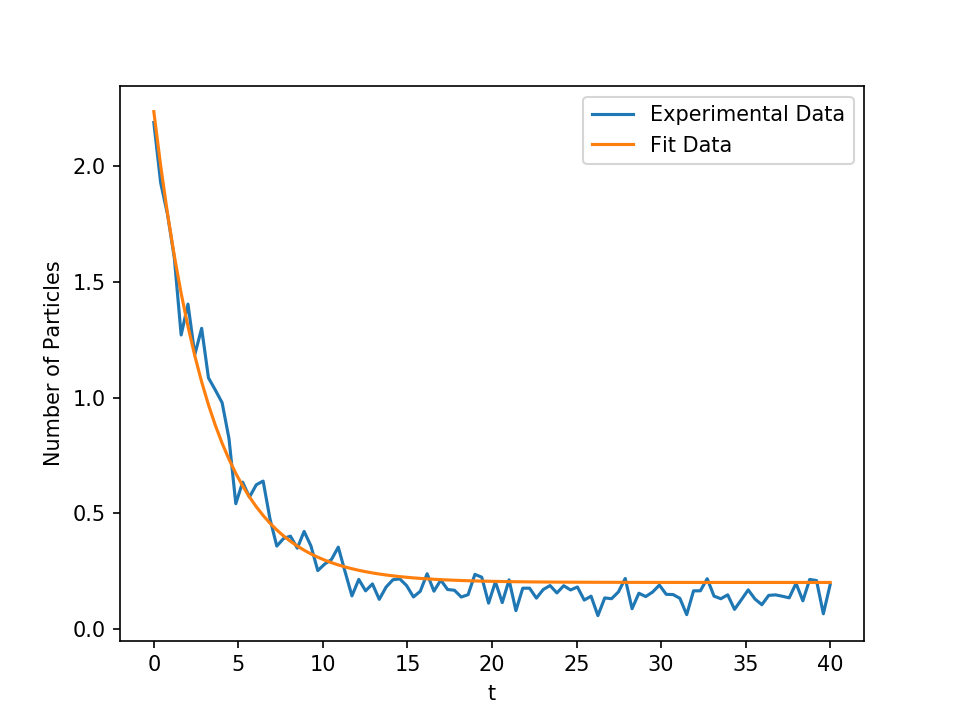

In [55]:
fig = plt.figure("Curve Fit")
plt.plot(t, num_particles, label='Experimental Data')
plt.plot(t, fit_line(t, best_pars), label='Fit Data')
plt.xlabel('t')
plt.ylabel('Number of Particles')
plt.legend()

# Problem 2e

Plot the histogram distributions of the three fit parameters.

<IPython.core.display.Javascript object>


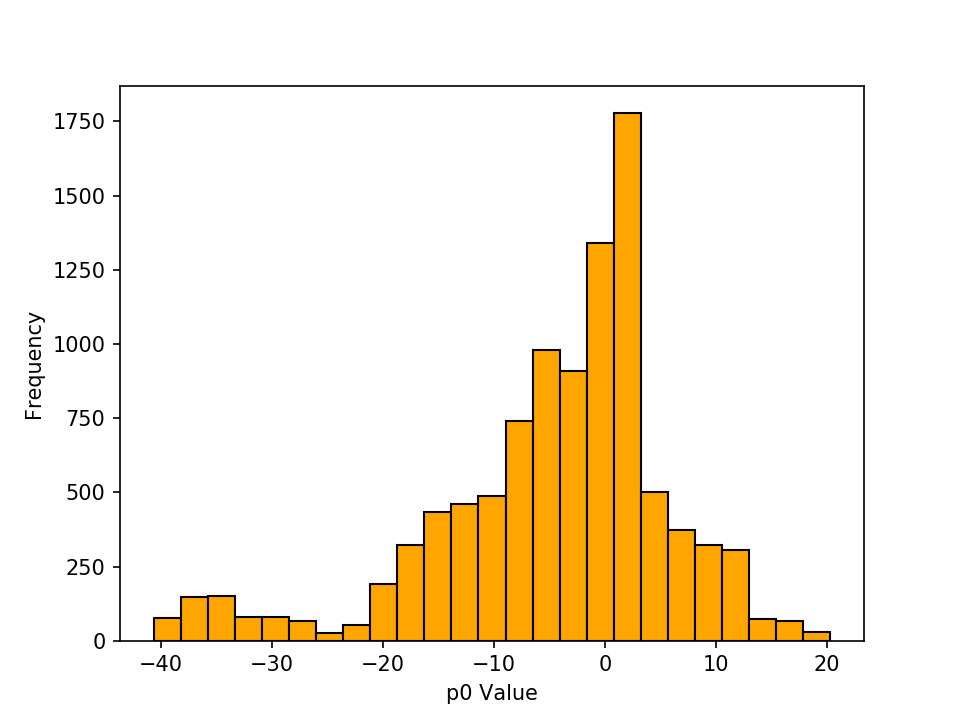

Text(0, 0.5, 'Frequency')

In [56]:
par_array = np.array(par_list)

p_0 = par_array[:,0]
p_1 = par_array[:,1]
p_2 = par_array[:,2]

fig2 = plt.figure('Distribution of p0 Values')
plt.hist(p_0, color='orange', bins=25, edgecolor='black')
plt.xlabel('p0 Value')
plt.ylabel('Frequency')

<IPython.core.display.Javascript object>


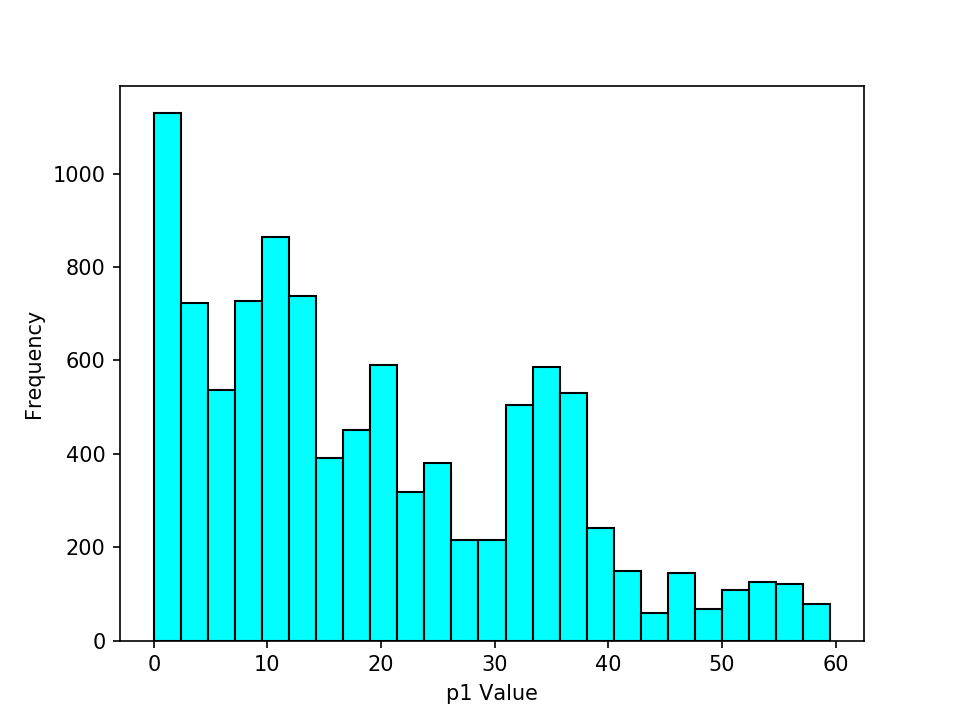

Text(0, 0.5, 'Frequency')

In [57]:
fig3 = plt.figure('Distribution of p1 Values')
plt.hist(p_1, color='cyan', bins=25, label='p1', edgecolor='black')
plt.xlabel('p1 Value')
plt.ylabel('Frequency')

<IPython.core.display.Javascript object>


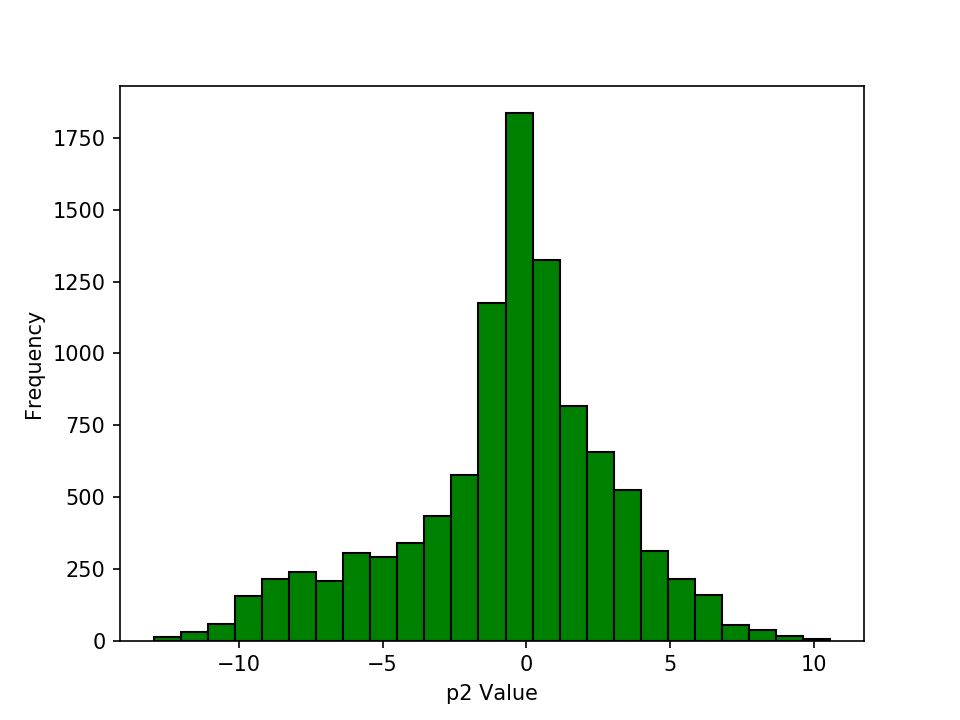

Text(0, 0.5, 'Frequency')

In [58]:
fig4 = plt.figure('Distribution of p2 values')
plt.hist(p_2, color='green', bins=25, edgecolor='black')
plt.xlabel('p2 Value')
plt.ylabel('Frequency')